In [1]:
from TABprocessor import *
import tokenizers
import tensorflow as tf
from tensorflow import keras
from transformers import AutoTokenizer, TFGPT2LMHeadModel, AutoConfig
import matplotlib.pyplot as plt

from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer
)


In [2]:
def tokenizer_preprocess(measurepitch):
    '''
    由于huggingface的分词会把类似4B4C这种带数字的分开，因此把数字和升降号换成字母
    '''
    xila = ['t', 'u', 'v', 'w', 'x', 'y', 'z', 'j', 'k'] 
    sentence = ''
    for cunum, cu in enumerate(measurepitch):
        if 'SUS' in cu or 'R' in cu:
            cu = cu.replace(' ', '')
            sentence += cu
            sentence += ' '
        else:
            notes = cu.split()
            for notenum, note in enumerate(notes):
                notes[notenum] = xila[int(note[0])] + note[1:]
                if len(note) > 2:
                    if note[-1] == '#':
                        notes[notenum] = notes[notenum][0:2] + 'j' 
                    elif note[-1] == '-':
                        notes[notenum] = notes[notenum][0:2] + 'k' 

            for note in notes:
                sentence += note
            sentence += ' '
    return sentence[0:-1]
            
def tokenizer_deprocess(sentence):
    '''
    希腊字母的逆变换
    '''
    measure = []
    xila = ['t', 'u', 'v', 'w', 'x', 'y', 'z', 'j', 'k']
    octave = [' 0', ' 1', ' 2', ' 3', ' 4', ' 5', ' 6', '#', '-']
    cus = sentence.split()
    for cu in cus:
        for i in range(len(xila)):
            cu = cu.replace(xila[i], octave[i])
        cu = cu[1:]
        measure.append(cu)
    return measure


In [3]:
def song_greek(song):
    '''
    对多个小节进行希腊字母化并组合成句
    '''
    song_sentence = ''
    for measure in song:
        song_sentence += tokenizer_preprocess(measure)
        song_sentence += ', '

    song_sentence = song_sentence[0:-2]
    return song_sentence

sub_dataset = readTAB('C:\\Users\\28056\\Desktop\\研究生\\AnimeTAB\\AnimeTAB\\clips\\')

#####0. [Air]てんとう虫(瓢虫)_14^21C.xml
#####1. [Air]てんとう虫(瓢虫)_2^5I.xml
#####2. [Air]てんとう虫(瓢虫)_42^49B.xml
#####3. [Air]てんとう虫(瓢虫)_6^13A.xml
#####4. [Air]回想录_9^20B.xml
#####5. [Air]夢語り_1^8A.xml
#####6. [Air]夢語り_9^16B.xml
#####7. [Air]银色_16^27B.xml
#####8. [Air]鸟之诗_10^27B.xml
#####9. [Air]鸟之诗_1^9I.xml
#####10. [Air]鸟之诗_28^43A.xml
#####11. [Air]鸟之诗_44^58C.xml
#####12. [Angel Beats!]Brave Song_16^25C.xml
#####13. [Angel Beats!]Brave Song_1^15A.xml
#####14. [Angel Beats!]Brave Song_26^49B.xml
#####15. [Angel Beats!]一番の宝物_1^8 I.xml
#####16. [Angel Beats!]一番の宝物_9^24 A.xml
#####17. [Beck]Face_13^23A.xml
#####18. [Beck]Face_25^33B.xml
#####19. [CLANNAD]メグメル(幻想)_1^15I.xml
#####20. [CLANNAD]メグメル(幻想)_23^30A.xml
#####21. [CLANNAD]メグメル(幻想)_31^49B.xml
#####22. [CLANNAD]东风_10^26A.xml
#####23. [CLANNAD]东风_1^9I.xml
#####24. [CLANNAD]团子大家族_25^32C.xml
#####25. [CLANNAD]团子大家族_33^48B.xml
#####26. [CLANNAD]团子大家族_9^24A.xml
#####27. [CLANNAD]欢乐岛_1^15I.xml
#####28. [CLANNAD]欢乐岛_24^34A.xml
#####29. [CLANNAD]欢乐岛_35^42C.

In [4]:

###2022.8.1

In [4]:
for songnum, song in enumerate(sub_dataset):
    for measurenum, measure in enumerate(song.time):
        for time in measure:
            if len(str(time)) >= 7:
                print('song{} measure{}: {}'.format(songnum, measurenum, measure))
                
  

In [6]:
a = [ 0.5, 0.5, 0.5, 0.5, 0.8333333333333335, 0.16666666666666652, 0.16666666666666652, 0.16666666666666652, 0.16666666666666652, 0.5000000000000004]
def fix_triple(a):
    '''
    去掉列表中的三连音时值，改成后十六
    '''
    triple_set = []
    triple, triple_pos = [], []
    for num, i in enumerate(a):
        if len(str(i)) >= 7 and str(i)[-4:-2] != '00':
            triple.append(i)
            triple_pos.append(num)
        if triple != [] and round(sum(triple), ndigits=4) % 0.25 == 0:
            triple_set.append((triple, triple_pos))
            triple, triple_pos = [], []
    for tset in triple_set:
        print(tset)

    #当三连音全满时
    
    for tset in triple_set:
        if len(tset[0])==3:
            assert len(set(tset[0]))==1
            #将三连音改成后十六
            for pos in tset[1]:
                a[pos] =round(a[pos] * 0.75, ndigits=4)
            a[tset[1][0]] = a[tset[1][0]] * 2
        #当三连音不满，比如用连音线把三个变成两个时：   
        elif len(tset[0])==2:
            for pos in tset[1]:
                a[pos] =round(min(tset[0]) * 1.5, ndigits=4)
    #最后把每个时值round一下保持整齐
    for i in range(len(a)):
        a[i] = round(a[i], ndigits=4)
    return a

   
    
            
fix_triple(a)

([0.8333333333333335, 0.16666666666666652], [4, 5])
([0.16666666666666652, 0.16666666666666652, 0.16666666666666652], [6, 7, 8])


[0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.125, 0.125, 0.5]

In [12]:
def vectorization(self, division=16):
    def fix_triple(a):
        '''
        去掉列表中的三连音时值，改成后十六
        '''
        triple_set = []
        triple, triple_pos = [], []
        for num, i in enumerate(a):
            if len(str(i)) >= 7 and str(i)[-4:-2] != '00':
                triple.append(i)
                triple_pos.append(num)
            if triple != [] and round(sum(triple), ndigits=4) % 0.25 == 0:
                triple_set.append((triple, triple_pos))
                triple, triple_pos = [], []
        for tset in triple_set:
            print(tset)

        #当三连音全满时
        ordinary_triples = [0.3333, 0.6666, 0.126666]
        for tset in triple_set:
            if len(tset[0])==3:
                extraformer, extralater = 0, 0
                try:
                    assert tset[0][0] in ordinary_triples and tset[0][-1] in ordinary_triples
                except:
                    for ordinary_triple in ordinary_triples:
                        formernote = round(tset[0][0] - ordinary_triple, ndigits=4)
                        laternote = round(tset[0][-1] - ordinary_triple, ndigits=4)
                        if formernote % 0.25 == 0:
                            extraformer = formernote
                            tset[0][0] = ordinary_triple
                        if laternote % 0.25 == 0:
                            extralater = laternote
                            tset[0][-1] = ordinary_triple
                #将三连音改成后十六
                for num, pos in enumerate(tset[1]):
                    a[pos] =round(a[pos] * 0.75, ndigits=4)
                a[tset[1][0]] = a[tset[1][0]] * 2 + extraformer
                a[tset[1][-1]] = a[tset[1][-1]] + extralater
            #当三连音不满，比如用连音线把三个变成两个时：   
            elif len(tset[0])==2:
                extraformer, extralater = 0, 0
                try:
                    assert tset[0][0] in ordinary_triples and tset[0][-1] in ordinary_triples
                except:
                    for ordinary_triple in ordinary_triples:
                        formernote = round(tset[0][0] - ordinary_triple, ndigits=4)
                        if formernote % 0.25 == 0:
                            extraformer = formernote
                            tset[0][0] = ordinary_triple
                        if laternote % 0.25 == 0:
                            extralater = laternote
                            tset[0][-1] = ordinary_triple
                    
                for pos in tset[1]:
                    a[pos] =round(min(tset[0]) * 1.5, ndigits=4)
                a[tset[1][0]] = a[tset[1][0]] + extraformer
                a[tset[1][-1]] = a[tset[1][-1]] + extralater
        #最后把每个时值round一下保持整齐
        for i in range(len(a)):
            a[i] = round(a[i], ndigits=4)
        return a

    
    
    measurenum = len(self.pitch)
    measurelist = []
    for i in range(measurenum):
        measurelist.append(self.choose_measure(i))

    pitchvec, fingervec = [], []
    for measure in measurelist:
        info = measure.info #
        beat = info.beat
        pitchseries, fingerseries= [], []
        fix_triple(measure.time)
        for i, index in enumerate(zip(measure.pitch, measure.finger, fix_triple(measure.time))):
            note = []
            finger = []
            for i in range(int(index[2] * (division/4))):
                if i == 0:
                    note.append(index[0])
                    finger.append(index[1])
                else:
                    note.append('SUS')
                    finger.append('SUS')

            for notezip in zip(note, finger):
                pitchseries.append(notezip[0])
                fingerseries.append(notezip[1])
        pitchvec.append(pitchseries)
        fingervec.append(fingerseries)
    vecsong = Tablature(pitch=pitchvec, finger=fingervec, time=self.time, info=self.info)
    return vecsong

song = sub_dataset[11]
vectorization(song).pitch[7]

['4F# 4C# 2F',
 'SUS',
 '2A#',
 'SUS',
 '4C# 3G#',
 'SUS',
 '2B',
 'SUS',
 '2A#',
 'SUS',
 '3C#',
 'SUS',
 '3F#',
 'SUS',
 '3E',
 'SUS']

In [4]:
for songnum, song in enumerate(sub_dataset):
    #print(songnum)
    x = song.vectorization(division=32)
    for measurenum, measure in enumerate(x.pitch):
        if x.info.beat == '4' and len(measure) != 32:
            print('song {} measure {}:'.format(songnum, measurenum))
            print(sub_dataset[songnum].pitch[measurenum])
            print(sub_dataset[songnum].time[measurenum])
            print()
    
   

song 98 measure 5:
['5C 2A', '4B 3E', '5C', '4B', '4A 3A', '4G 4C', '4A 3B', '4C', '4G 3B', '5D 3E']
[0.5, -0.125, 0.0625, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

song 171 measure 8:
['4C 3E 3C', '3G', '4C', '3A# 2A#', '3F', '3A#']
[3.0, 0.25, 0.25, 3.0, 0.25, 0.25]

song 244 measure 3:
['4F# 4D 2E', '3D', '3G', '4G', '4F# 3G', '4G 3G', '4G 3D', '3G']
[0.5, 0.5, 0.5, 0.25, 0.125, 0.875, 0.5, 0.5]

song 244 measure 8:
['4A 4D 2A', '4B 4E', '4A 4D', '4B 4E', '3D', '3G', '4E', '3G', '4E', '4B', '4E', '3G']
[0.5, 0.5, 0.5, 1.0, 0.5, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, -2.5]

song 244 measure 11:
['4A 4D 2A', '4B 4E', '4A 4D', '4B 4E', '3D', '3G', '4E', '3G', '4E', '4B', '4E', '3G']
[0.5, 0.5, 0.5, 1.0, 0.5, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, -2.5]

song 399 measure 8:
['4A 4F# 4D 2E', '3G 3D', '3G 3D', '3G 3D', '3A 3F', '3B 3G', '3B 3G', '4C 3A', '4D 3B']
[3.0, 0.25, 0.25, 0.5, 0.25, 0.25, 0.5, 0.25, 0.25]

song 452 measure 0:
['4E 3C', '4F', '4E 4C', '4A', '4G 2G', '3G', '3B', '3G', '4D', '3G']
[0.3333

In [29]:
sub_dataset[117].info.beat

'4'

In [4]:
print(sub_dataset[98].pitch[5])
print(sub_dataset[98].time[5])

['5C 2A', '4B 3E', '5C', '4B', '4A 3A', '4G 4C', '4A 3B', '4C', '4G 3B', '5D 3E']
[6.0, 1.0, 1.0, 4.0, 6.0, 6.0, 6.0, 6.0, 6.0, -38.0]


In [16]:
x.info.beat

'4'

In [12]:
sub_dataset[2].pitch

In [16]:
from xml.dom import minidom
from xml.dom.minidom import parse
import os

tree = parse('C:\\Users\\28056\\Desktop\\研究生\\AnimeTAB\\AnimeTAB\\clips\\[全金属狂潮]那就是爱吧_5^15A.xml')
measures = tree.getElementsByTagName('measure')
print(measures)

[<DOM Element: measure at 0x1ab9d2e1e50>, <DOM Element: measure at 0x1abe1859f70>, <DOM Element: measure at 0x1abe1654dc0>, <DOM Element: measure at 0x1abe1824550>, <DOM Element: measure at 0x1ab9da35820>, <DOM Element: measure at 0x1abbd8dfee0>, <DOM Element: measure at 0x1abe26e4280>, <DOM Element: measure at 0x1abe1cb4040>, <DOM Element: measure at 0x1abe21485e0>, <DOM Element: measure at 0x1abe1d67040>, <DOM Element: measure at 0x1abe19ebee0>, <DOM Element: measure at 0x1abe180d9d0>, <DOM Element: measure at 0x1abe27528b0>, <DOM Element: measure at 0x1abe25ef310>, <DOM Element: measure at 0x1abff5ee790>, <DOM Element: measure at 0x1ad8c20d430>]


In [5]:
###2022.8.1

In [22]:
#备份一份歌曲
import copy
sentences, root_sentences = [], []
copy_dataset = []
for song in sub_dataset:
    copy_dataset.append(copy.deepcopy(song))
    

In [23]:
all_keys = ['C', 'D', 'E', 'F', 'G', 'A', 'B', 'C#', 'D#', 'F#', 'G#', 'A#']
for i, osong in enumerate(copy_dataset):
    if i not in [397, 400, 411, 413]:
        for key in all_keys:
            song = copy.deepcopy(osong)
            newsong = Tablature(pitch=None, finger=None, time=None)
            newsong.pitch = song.key_shift(key)
            newsong.finger = song.finger
            newsong.time = song.time
            newsong.info = song.info
            sentence = song_greek(newsong.pitch)

            root_song = newsong.root_and_melody()
            root_sentence = song_greek(root_song.pitch)
            
            sentences.append(sentence)
            root_sentences.append(root_sentence)
            del(song)

In [ ]:
same_measures, not_same_measures = [], []
for index in zip(sentences, root_sentences):
    if index[0] == index[1]:
        same_measures.append(index)
    else:
        not_same_measures.append(index)
        
import random
random.shuffle(not_same_measures)
print(len(same_measures))
print(len(not_same_measures))

1481
4881


In [ ]:
samechar, notsamechar = 0, 0
for index in not_same_measures:
    for i in zip(index[0], index[1]):
        if i[0] == i[1]:
            samechar += 1
        else:
            notsamechar +=1
            
print(samechar)
print(notsamechar)

In [ ]:
root_positions = []
for index_measure in not_same_measures:
    root_position = []
    full, root = index_measure[0].split(), index_measure[1].split()
    if len(full) != len(root):
        print(index_measure)
    '''for i in range(len(full)):
        if full[i] == root[i]:
            root_position.append(0)
        else:
            root_position.append(1)
            
    root_positions.append(root_position)    
    '''
    
    

('xExCvA SUS SUS wAwE SUS SUS SUS xG SUS SUS xGwA SUS SUS SUS', 'xEvA SUS SUS SUS wAwE SUS SUS SUS xG SUS SUS SUS xG SUS SUS SUS')
('xDwEvGvD SUS SUS R wGwDwC SUS SUS SUS SUS SUS SUS SUS wAwFj SUS SUS', 'xDvD SUS SUS SUS wG SUS SUS SUS SUS SUS SUS SUS wA SUS SUS SUS')
('wGvG wD wA wBvG wB wAvA wE wA xCvA wA wE', 'wGvG SUS wA wBvG SUS wB wAvA SUS wA xCvA wA SUS')
('xBxE SUS wE SUS wE SUS', 'xB SUS wE SUS wE wE SUS')
('wBwDvGvG SUS SUS wAvG SUS SUS SUS SUS SUS SUS SUS vD SUS SUS SUS', 'wBvG SUS SUS SUS wAvG SUS SUS SUS SUS SUS SUS SUS vD SUS SUS SUS')
('xBxD SUS SUS yCxCvA SUS wE SUS wA SUS SUS xE SUS SUS', 'xB SUS SUS SUS yCvA SUS SUS SUS wA SUS SUS SUS xE SUS SUS')
('wF SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS xC SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS xF SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS xA SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS 

In [35]:
import os
from tokenizers.models import BPE
from tokenizers import Tokenizer
from tokenizers.decoders import ByteLevel as ByteLevelDecoder
from tokenizers.normalizers import NFKC, Sequence
from tokenizers.pre_tokenizers import ByteLevel
from tokenizers.trainers import BpeTrainer
import tensorflow as tf
from transformers import GPT2Config, TFGPT2LMHeadModel, GPT2Tokenizer
# loading tokenizer from the saved model path

'''class BPE_token(object):
    def __init__(self):
        self.tokenizer = Tokenizer(BPE())
        self.tokenizer.normalizer = Sequence([
            NFKC()
        ])
        self.tokenizer.pre_tokenizer = ByteLevel()
        self.tokenizer.decoder = ByteLevelDecoder()

    def bpe_train(self, sentences):
        trainer = BpeTrainer(vocab_size=50000, show_progress=True, inital_alphabet=ByteLevel.alphabet(), special_tokens=[
            "<s>",
            "<pad>",
            "</s>",
            "<unk>",
            "<mask>"
        ])
        self.tokenizer.train_from_iterator(sentences, trainer=trainer)

    def save_tokenizer(self, location, prefix=None):
        if not os.path.exists(location):
            os.makedirs(location)
        self.tokenizer.model.save(location, prefix)
music_tokenizer = BPE_token()
# train the tokenizer model
music_tokenizer.bpe_train(sentences)
# saving the tokenized data in our specified folder 
save_path = 'tokenized_data'
music_tokenizer.save_tokenizer(save_path)

music_tokenizer = GPT2Tokenizer.from_pretrained(save_path)
music_tokenizer.add_special_tokens({
  "eos_token": "</s>",
  "bos_token": "<s>",
  "unk_token": "<unk>",
  "pad_token": "<pad>",
  "mask_token": "<mask>"
})'''

0

In [38]:
music_tokenizer = Tokenizer(models.BPE())
music_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)
#music_tokenizer.pre_tokenizer.pre_tokenize_str(sentence1)

trainer = trainers.BpeTrainer(vocab=5000, special_tokens=["END"])
music_tokenizer.train_from_iterator(root_sentences, trainer=trainer)
music_tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)

In [40]:
music_tokenizer.decode(music_tokenizer.encode(root_sentences[0]).ids)

'wAvF ĠwG ĠwAvF ĠxC ĠwA ĠwG , ĠwGvE ĠwA ĠwDvE ĠwG ĠwEvE ĠwDvE , ĠwCvF ĠvAvF ĠwC ĠwDvF ĠwG ĠwEvF , ĠwEvE ĠwG ĠwA ĠwBvE ĠwG ĠwA , ĠxCvF ĠwA ĠwGvF ĠwA ĠxC ĠwA ĠwG ĠwA ĠxC , ĠxDvE ĠxC ĠxD ĠxG ĠxEvE ĠxD ĠxE , ĠxCvF ĠwA ĠwFwC ĠxDvE ĠwB ĠwG , ĠwDvA ĠwCjvE ĠwAvA'

In [42]:
string_tokenized = ''
for sen in sentences:
    string_tokenized += sen
    
string_tokenized = music_tokenizer.encode(string_tokenized).ids

examples = []
block_size = 50
BATCH_SIZE = 64
BUFFER_SIZE = 1000
for i in range(0, len(string_tokenized) - block_size + 1, block_size):
    examples.append(string_tokenized[i:i + block_size])
val_examples = examples[0:len(examples)//10]
examples = examples[len(examples)//10 + 1:]

In [43]:
print(len(sentences))
print(len(root_sentences))

6516
6516


In [15]:
inputs, outputs = [], []
for index in not_same_measures:
    if len(index[0]) < 100:
        inputs.append(paddings(music_tokenizer.encode(index[1]))) 
        outputs.append(paddings(music_tokenizer.encode(index[0])))

    

In [16]:
BATCH_SIZE = 64

test_inputs, test_outputs = inputs[:250], outputs[:250]
val_inputs, val_outputs = inputs[250:500], outputs[250:500]
inputs, outputs = inputs[500:], outputs[500:]

dataset = tf.data.Dataset.from_tensor_slices((inputs, outputs))
dataset = dataset.shuffle(1000).batch(BATCH_SIZE, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((val_inputs, val_outputs))
val_dataset = val_dataset.shuffle(1000).batch(BATCH_SIZE, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_outputs))
test_dataset = test_dataset.shuffle(1000).batch(BATCH_SIZE, drop_remainder=True)

In [17]:
from transformers import GPT2Config, TFGPT2LMHeadModel
# creating the configurations from which the model can be made
config = GPT2Config(
    vocab_size=music_tokenizer.vocab_size,
    bos_token_id=music_tokenizer.bos_token_id,
    eos_token_id=music_tokenizer.eos_token_id,
    pad_token_id=0,
    n_layer=4,
    n_head=4,
    n_embed=256
)

# creating the model
model = TFGPT2LMHeadModel(config)

# defining our optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
# definining our loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# defining our metric which we want to observe
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
# compiling the model
model.compile(optimizer=optimizer, loss=[loss, *[None] * model.config.n_layer], metrics=[metric])
num_epoch = 50
#model.summary()

In [18]:
history = model.fit(dataset, validation_data=val_dataset, epochs=num_epoch)

Epoch 1/50
66/66 [==============================] - 35s 441ms/step - loss: 0.9012 - accuracy: 0.8924 - val_loss: 0.4708 - val_accuracy: 0.9297
Epoch 2/50
66/66 [==============================] - 29s 434ms/step - loss: 0.3889 - accuracy: 0.9453 - val_loss: 0.3355 - val_accuracy: 0.9530
Epoch 3/50
66/66 [==============================] - 29s 434ms/step - loss: 0.2959 - accuracy: 0.9577 - val_loss: 0.2756 - val_accuracy: 0.9585
Epoch 4/50
66/66 [==============================] - 29s 436ms/step - loss: 0.2518 - accuracy: 0.9619 - val_loss: 0.2625 - val_accuracy: 0.9593
Epoch 5/50
66/66 [==============================] - 29s 440ms/step - loss: 0.2268 - accuracy: 0.9644 - val_loss: 0.2428 - val_accuracy: 0.9619
Epoch 6/50
66/66 [==============================] - 29s 442ms/step - loss: 0.2093 - accuracy: 0.9658 - val_loss: 0.2187 - val_accuracy: 0.9639
Epoch 7/50
66/66 [==============================] - 29s 438ms/step - loss: 0.1965 - accuracy: 0.9669 - val_loss: 0.2152 - val_accuracy: 0.9648

In [19]:
from transformers import WEIGHTS_NAME, CONFIG_NAME
import os
output_dir = './model_7_29/'
# creating directory if it is not present
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
output_model_file = os.path.join(output_dir, WEIGHTS_NAME)
output_config_file = os.path.join(output_dir, CONFIG_NAME)
# save model and model configs

model.save_pretrained(output_dir)
model_to_save.config.to_json_file(output_config_file)

In [ ]:
# save tokenizer
music_tokenizer.save('music_tokenizer_7_28.json')

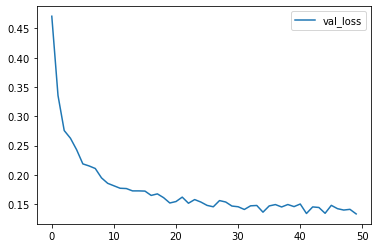

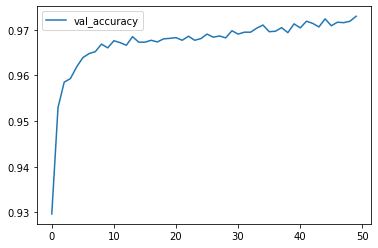

In [20]:
def show_history(history, aspect):
    plt.figure()
    plt.plot(history.history[aspect], label=aspect)
    plt.legend()
show_history(history, 'val_loss')
show_history(history, 'val_accuracy')

In [33]:
'''text = "wFwD xC xC wF xC"
# encoding the input text
input_ids = music_tokenizer.encode(text)
input_ids = tf.reshape(input_ids, [1, -1])
# getting out output
beam_output = model.generate(
  input_ids,
  max_length = 50,
  num_beams = 5,
  temperature = 0.7,
  no_repeat_ngram_size=2,
  num_return_sequences=5
)'''

In [21]:
print('input:  {}'.format(music_tokenizer.decode([i for i in inputs[8] if i != 0])))
print('truth:  {}'.format(music_tokenizer.decode([i for i in outputs[8] if i != 0])))


input:  xGvAj SUS xF SUS xF SUS xE SUS xEvAj SUS xD SUS xE SUS xF SUS
truth:  xGwGwDjvAj SUS xF SUS xF SUS xE SUS xEwAwFvAj SUS xD SUS xE SUS xF SUS


In [22]:
index=[2,3,4]
for inputnum in index:
    result = model.generate(tf.reshape([i for i in test_inputs[inputnum] if i != 0], [1, -1]), 
                   max_length=120,
                   temperature=1)
    print('input:  {}'.format(music_tokenizer.decode([i for i in test_inputs[inputnum] if i != 0])))
    print('truth:  {}'.format(music_tokenizer.decode([i for i in test_outputs[inputnum] if i != 0])))
    print('result: {}'.format(music_tokenizer.decode(result[0]).replace('<s>', '')))
    print()

input:  wAvA SUS wA SUS wA SUS wBvA SUS xC SUS xD SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS
truth:  wAvA SUS wA SUS wA SUS wBwGvA SUS xCwA SUS xDwB SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS
result: wAvA SUS wA SUS wA SUS wBvA SUS xC SUS xD SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS

input:  xCvA SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS wG SUS SUS SUS
truth:  xCwAwEvA SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS wG SUS SUS SUS
result: xCvA SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS SUS wG SUS SUS SUS

input:  xCvF SUS wCvF SUS wCvF SUS wCvF SUS SUS SUS xCvF SUS xCvF SUS xCvF SUS
truth:  xCvF SUS wCvGvF SUS wCvGvF SUS wCvGvF SUS SUS SUS xCwAwAvGvF SUS xCwAwAvGvF SUS xCwAwAvGvF SUS
result: xCvF SUS wCvF SUS wCvF SUS wCvF SUS SUS SUS xCvF SUS xCvF SUS xCvF SUS



In [40]:
music_tokenizer.decode(beam_output[4])

'wFwD xC xC wF xC<s><s>wC<s>xE<s>xC<s>xD<s>xG<s>wD<s>wF<s>wA<s>wB<s>xA<s>yC<s>xF<s>vA<s>y<s>wG<s>wE<s>vD<s>xB<s>yE<s> SUS SUS wF wF'

In [ ]:
def song_degeek(str1):
    measures = str1.split(', ')
    for measure in measures:
        print(tokenizer_deprocess(measure))
        
sample = music_tokenizer.decode(beam_output[0])       
song_degeek(sample)

In [ ]:
tokenizer_deprocess(text)

In [ ]:
tokenizer_preprocess(song.pitch[0])

In [ ]:
music_tokenizer = Tokenizer(models.BPE())
music_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)
#music_tokenizer.pre_tokenizer.pre_tokenize_str(sentence1)

trainer = trainers.BpeTrainer(vocab=5000, special_tokens=["END"])
music_tokenizer.train_from_iterator(sentences, trainer=trainer)
music_tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)

In [ ]:
аоуыэяёюе

б、в、г、д、ж、з、л、м、н、р、й

п、ф、к、т、ш、с、х、ц、ч、щ